In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import joblib
import random


# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


# sklearn
import sklearn
import sklearn.model_selection
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


# custom libs
import sys

path = '/content/drive/Shareddrives/Machine Learning/'
data_path = path + 'data/'
KNN_path = path + 'code/KNN/'
sys.path.append(path + 'code/')
from load_dataframe import load_dataframe
from confusionMatrix import plot_confusion_matrix


Mounted at /content/drive


In [2]:
# set seeds
random.seed(0)
np.random.seed(0)

#Load Dataset

In [3]:
df = load_dataframe( data_path + 'features.npz', data_path + 'name_class.csv')

classes = df["class"].unique()

# Class codes
class_code = dict( zip( df["class"].astype('category').cat.categories, np.arange( 0, len( classes) ) ) )
print( "\nClass encoding: ", class_code )

print(df.shape)

Number of features:  1280
Original number of examples:  19520
Final number of examples:  18748

Class encoding:  {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}
(18748, 1282)


In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1272,1273,1274,1275,1276,1277,1278,1279,class,img_name
0,1.110234,1.507227,0.000000,0.000000,0.118538,0.000000,0.611660,0.000000,0.216659,0.0,...,0.000000,0.582409,0.0,0.000000,0.000000,0.292292,0.080777,0.342733,CN,ADNI_941_S_4292_MR_ADNI_gre_field_mapping_br_r...
1,0.377716,0.804323,0.000000,0.044572,0.469181,0.000000,1.109573,0.000000,0.427474,0.0,...,0.018944,0.851525,0.0,0.239364,0.111541,0.000000,0.363659,0.683264,CN,ADNI_941_S_4292_MR_ADNI_gre_field_mapping_br_r...
2,1.291019,0.071864,0.177774,1.815525,0.103777,0.035584,0.019683,0.000000,0.000000,0.0,...,0.000000,0.226819,0.0,0.445593,0.652496,0.022925,0.000000,0.357433,CN,ADNI_941_S_4292_MR_ADNI_gre_field_mapping_br_r...
3,0.390894,0.746412,0.039011,0.298714,1.402811,0.000000,0.052603,0.098031,0.058295,0.0,...,0.004990,0.480598,0.0,0.000000,1.700429,0.416542,0.039750,2.452053,CN,ADNI_941_S_4292_MR_ADNI_gre_field_mapping_br_r...
4,1.896747,0.958916,0.002194,0.096892,0.260261,0.000000,0.861980,0.043710,0.040442,0.0,...,0.079554,0.058523,0.0,0.100710,0.003879,0.023642,0.020626,0.359759,CN,ADNI_941_S_4292_MR_ADNI_gre_field_mapping_br_r...


In [5]:
# data split
X = df.drop( columns=["class", "img_name"] )
y = df["class"].copy()

print('X shape: ',X.shape)
print('Y shape: ',y.shape)

# treino e teste
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.1, random_state=0)

X shape:  (18748, 1280)
Y shape:  (18748,)


#Training

In [6]:
nfolds = 5
kf = KFold( n_splits=nfolds, shuffle=True, random_state=0 )

ngs = [ 1,3,5,7,11 ]
results = [ cross_val_score( KNeighborsClassifier(n_neighbors=n), x_train, y_train, cv=kf ) for n in ngs ]

In [7]:
# print results
pd.options.display.float_format = "{:,.4f}".format

results_data = [ (results[i].mean(), results[i].std()) for i in range(len(ngs) )] 

results_df = pd.DataFrame( data = results_data, columns = ["mean", "std"] )
results_df.insert( 0, "KNN", ngs )

print( results_df.to_string(index=False), "\n" )

# best result
bestN = ngs[ np.argmax(results_data[:][0]) ]
print( "best N: ", bestN )

bestKNN = sklearn.neighbors.KNeighborsClassifier(n_neighbors=bestN)
bestKNN.fit(x_train, y_train)
print("bestKNN:", bestKNN.score(x_test, y_test))

# save KNN model
filename = KNN_path + 'KNN' + str(bestN) + '.pkl'
joblib.dump(bestKNN, open(filename, 'wb'))

 KNN   mean    std
   1 0.5773 0.0040
   3 0.5345 0.0056
   5 0.5301 0.0093
   7 0.5209 0.0073
  11 0.5031 0.0058 

best N:  1
bestKNN: 0.5941333333333333


#Evaluation metrics

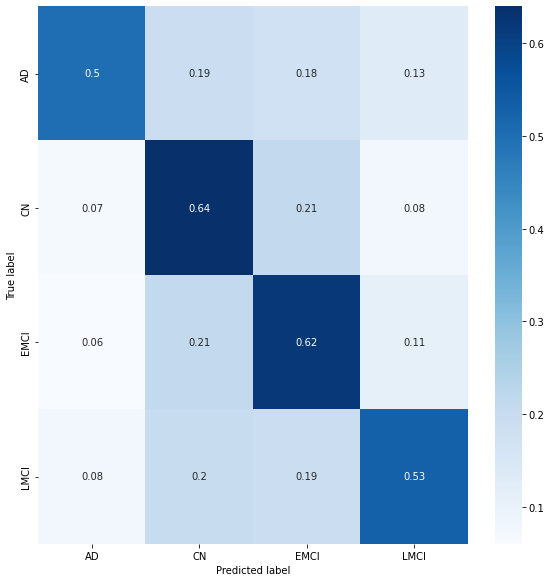

  class  Acurácia  Sensitividade  Especificidade
0    AD    0.8677         0.5019          0.9290
1    CN    0.7381         0.6361          0.7957
2  EMCI    0.7440         0.6207          0.8033
3  LMCI    0.8384         0.5327          0.9015


In [10]:
y_pred = bestKNN.predict(x_test)
y_pred = pd.DataFrame(y_pred)
y_true = pd.DataFrame(y_test)

y_pred = y_pred[0].astype('category').cat.codes
y_true = y_true["class"].astype('category').cat.codes
plot_confusion_matrix(y_true, y_pred, list(class_code.keys()))

#Load model

In [9]:
# best n = 1
filename = KNN_path + 'KNN1.pkl'
bestKNN = joblib.load(open(filename, 'rb'))